#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Нужно спрогнозировать количество заказов такси на следующий час. 

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import timeit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# Nan элементов нет - уже хорошо
df[df.isnull().any(1)]

,num_orders
datetime,


In [4]:
# Нулевых значений много, но это номально для такого времени
df[df.num_orders == 0]

,num_orders
datetime,
2018-03-01 05:20:00,0
2018-03-01 05:40:00,0
2018-03-01 05:50:00,0
2018-03-01 06:00:00,0
2018-03-01 06:10:00,0
...,...
2018-08-24 05:50:00,0
2018-08-26 05:40:00,0
2018-08-29 07:00:00,0


In [5]:
# Нулевых стало гораздо меньше
df.sort_index(inplace=True)
df = df.resample('1H').sum() 
df[df.num_orders == 0]

,num_orders
datetime,
2018-04-06 06:00:00,0


### Вывод

Данные проверены. Сделано ресемплирование по 1 часу.

## Анализ

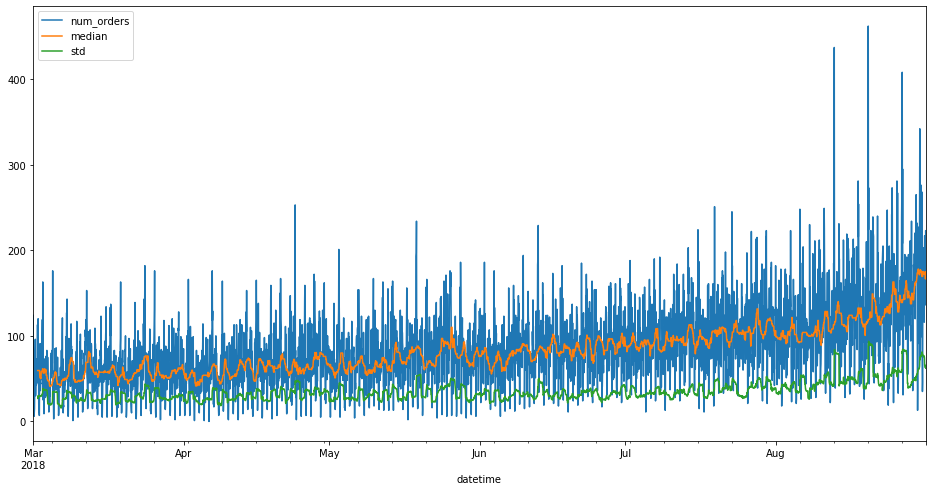

In [6]:
df['median'] = df['num_orders'].rolling(24).median()
df['std'] = df['num_orders'].rolling(24).std()
plt.figure(figsize=(16, 8))
df.plot(ax=plt.gca())

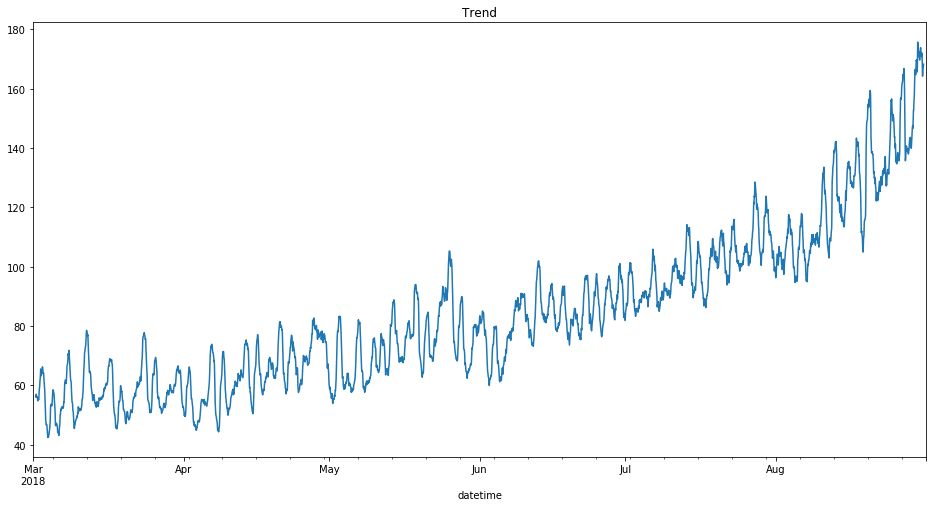

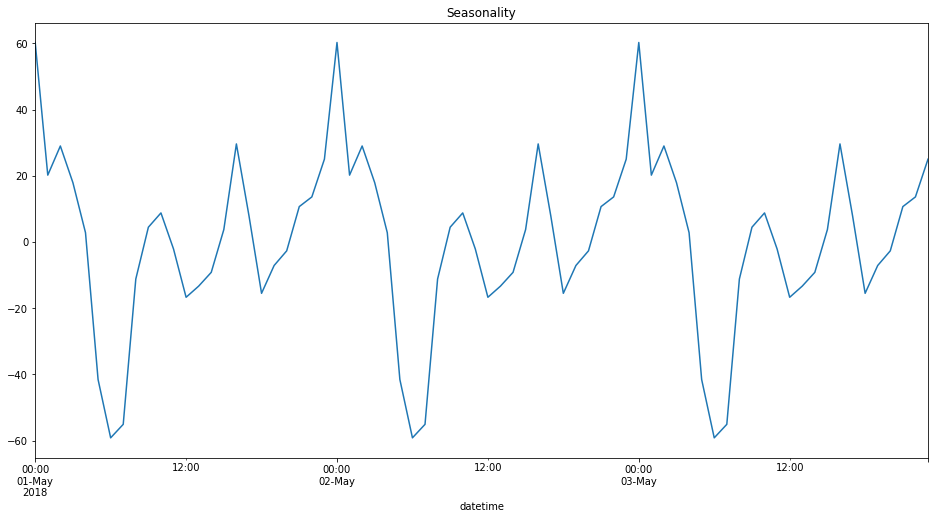

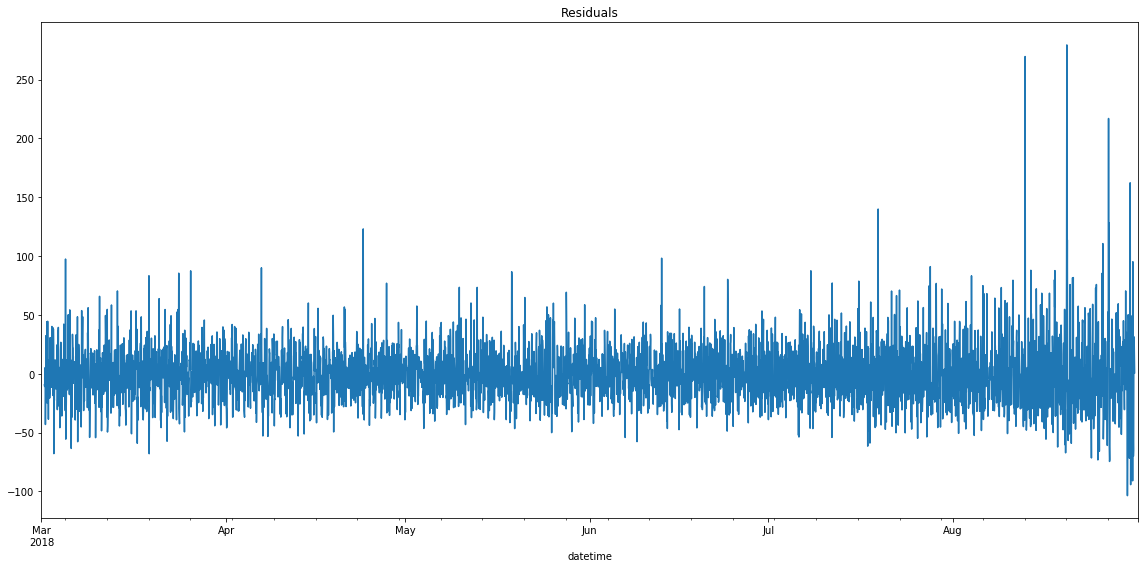

In [7]:
decomposed =  seasonal_decompose(df['num_orders'])

plt.figure(figsize=(16, 8))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.figure(figsize=(16, 8))
decomposed.seasonal['2018-05-01':'2018-05-03'].plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.figure(figsize=(16, 8))
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

### Вывод

Ряд явно не стационарен. Очень много шума, помимо тренда и сезонности. Достаточно много выборосов, особенно в конце, там где тестовая выборка, исходя из этого можно предположить, на тестовых данных модель будет показывать гораздо худшие результаты, чем на тренировочной. Вообще такие выбросы решаются ресэмплированием на большие промежутки времени, насколько знаю, но по условию нужно именно 1 час.

## Обучение

In [8]:

def make_features(data, max_lag, max_rol):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        data['shift_{}'.format(lag)] = data['num_orders'].shift(1) - data['num_orders'].shift(lag+1)
    
    for rol in range(2, max_rol + 1):
        data['rol_{}'.format(rol)] = data['num_orders'].shift().rolling(rol).mean()
    
make_features(df, 24, 10)
df['trend'] = decomposed.trend.shift()
df['seasonal'] = decomposed.seasonal.shift()
df['resid'] = decomposed.resid.shift()

In [9]:
train, test = train_test_split(df, shuffle=False, test_size=0.10)

In [10]:
train = train.dropna()
x_train = train.drop('num_orders', axis = 1)
y_train = train.num_orders

test = test.dropna()
x_test = test.drop('num_orders', axis = 1)
y_test = test.num_orders

def mashtab(x_train, x_test, numeric):
    pd.options.mode.chained_assignment = None
    scaler = StandardScaler()
    scaler.fit(x_train[numeric]) 
    x_train[numeric] = scaler.transform(x_train[numeric])
    x_test[numeric] = scaler.transform(x_test[numeric]) 
    return [x_train, x_test]    

x_train, x_test = mashtab(x_train, x_test, x_train.dtypes[x_train.dtypes != 'object'].index.tolist())

In [11]:
def gridsearch(result, name, model, params, x, y, cv = 5, scoring = "neg_mean_squared_error"):
    if 'LinearRegression' in name:
        model_obj = model()
    else:
        model_obj = model(random_state = 10)  
    grid = GridSearchCV(model_obj, params, scoring = scoring, cv = cv)
    grid.fit(x, y)
    result = result.append({'score':np.abs(grid.best_score_)**0.5 ,'name':name,'model':grid.best_estimator_}, ignore_index=True)
    return result    

In [12]:
result = pd.DataFrame({'score':[],'name':[],'model':[]})

In [13]:
%%time
tcv = TimeSeriesSplit(n_splits=5)
param_grid = {'fit_intercept': [False]}
result = gridsearch(result, 'LinearRegression fit_intercept = False', LinearRegression, param_grid, x_train, y_train, tcv)
param_grid = {'fit_intercept': [True]}
result = gridsearch(result, 'LinearRegression fit_intercept = True', LinearRegression, param_grid, x_train, y_train, tcv)

CPU times: user 707 ms, sys: 1.09 s, total: 1.8 s
Wall time: 1.75 s


In [14]:
%%time
param_grid = {
     'max_depth': range(4,7) ,
       'min_samples_leaf': range(4,7),
#      'min_samples_split': range(4,7),
     'n_estimators': [50, 100, 200] }
result = gridsearch(result, 'RandomForestRegressor', RandomForestRegressor, param_grid, x_train, y_train, tcv)

CPU times: user 6min, sys: 456 ms, total: 6min
Wall time: 6min 1s


In [15]:
result.sort_values(by='score', ascending = True)[['name','score']]

,name,score
2,RandomForestRegressor,2.503168e+01
0,LinearRegression fit_intercept = False,1.031302e+02
1,LinearRegression fit_intercept = True,1.497628e+11


### Вывод

Обучены 3 модели. У линейной регресси оочень большое значение метрики, что странно.

## Тестирование

In [16]:
result['predict'] = result.apply(lambda x: x.model.predict(x_test).astype(int), axis=1)
result['y_score'] = result.apply(lambda x:  mean_squared_error(x.predict, y_test)**0.5 , axis=1)
result= result.sort_values(by = 'y_score', ascending = True)
result = result.sort_values(by='y_score', ascending = True)
display(result[['name', 'y_score']])

,name,y_score
1,LinearRegression fit_intercept = True,41.733799
2,RandomForestRegressor,42.071092
0,LinearRegression fit_intercept = False,77.737660


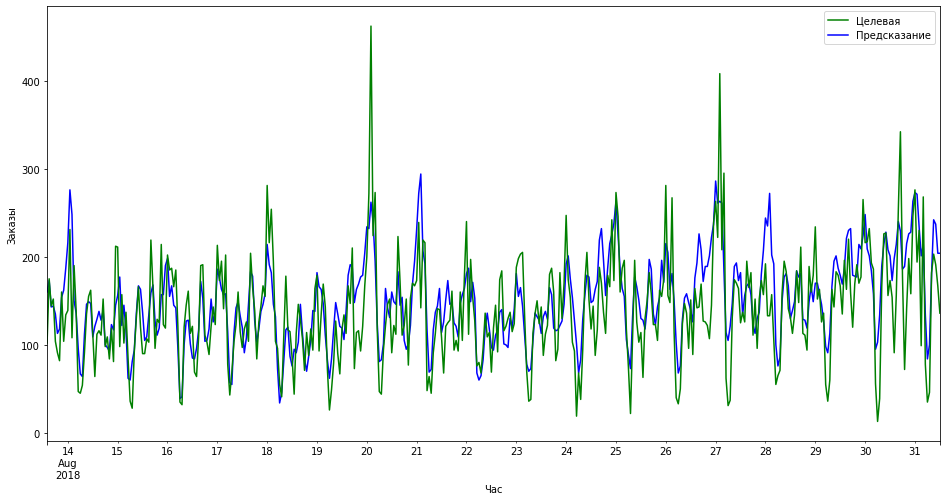

In [17]:
plt.figure(figsize=(16, 8))

pd.Series(result.iloc[0,].predict, index = y_test.index).plot(ax=plt.gca(), color='blue')
y_test.plot(ax=plt.gca(), color='green')

blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='Предсказание')
green_line = mlines.Line2D([], [], color='green', markersize=15, label='Целевая')
plt.legend(handles=[green_line,blue_line])
plt.ylabel('Заказы')
plt.xlabel('Час')
plt.show()



### Вывод

Предположение подтверждено. Скорее всего из-за выбросов на тестовой выборке модели ведут себя гораздо хуже. Линейная регрессия показав худшую метрику на тренировочной выборке показывает лучшую на тесте. Я не знаю как это объяснить.